<a href="https://colab.research.google.com/github/whiteprompt/r-d-machine-learning/blob/master/featuretools_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install featuretools==1.7.0 category_encoders --quiet

In [ ]:
import pandas as pd
import numpy as np

import featuretools as ft

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/woodwork/__init__.py:23: FutureWarning: Woodwork may not support Python 3.7 in next non-bugfix release.
  "Woodwork may not support Python 3.7 in next non-bugfix release.", FutureWarning
/usr/local/lib/python3.7/dist-packages/featuretools/__init__.py:67: FutureWarning: Featuretools may not support Python 3.7 in next non-bugfix release.
  FutureWarning,


In [ ]:
train = pd.read_csv('./data/raw/application_train.csv.gz')
test = pd.read_csv('./data/raw/application_test.csv.gz')
bureau = pd.read_csv('./data/raw/bureau.csv.gz')
bureau_balance = pd.read_csv('./data/raw/bureau_balance.csv.gz')

In [ ]:
# Add identifying column
train['set'] = 'train'
test['set'] = 'test'
test["TARGET"] = np.nan

# Append the dataframes
app = train.append(test, ignore_index=True)

## Entities and Entitysets

In [ ]:
# Entity set with id applications
es = ft.EntitySet(id='clients')

In [ ]:
# Entities with a unique index
es = es.add_dataframe(
    dataframe_name='application',
    dataframe=app,
    index='SK_ID_CURR'
)

es = es.add_dataframe(
    dataframe_name='bureau',
    dataframe=bureau,
    index='SK_ID_BUREAU'
)

# Entities that do not have a unique index
es = es.add_dataframe(
    dataframe_name='bureau_balance',
    dataframe=bureau_balance,
    make_index=True,
    index='bureaubalance_index'
)

In [ ]:
es

Entityset: clients
  DataFrames:
    application [Rows: 356255, Columns: 123]
    bureau [Rows: 1716428, Columns: 17]
    bureau_balance [Rows: 27299925, Columns: 4]
  Relationships:
    No relationships

## Relationships

In [ ]:
es = es.add_relationship(
    parent_dataframe_name='application',
    parent_column_name='SK_ID_CURR',
    child_dataframe_name='bureau',
    child_column_name='SK_ID_CURR'
)

es = es.add_relationship(
    parent_dataframe_name='bureau',
    parent_column_name='SK_ID_BUREAU',
    child_dataframe_name='bureau_balance',
    child_column_name='SK_ID_BUREAU'
)

In [ ]:
es

Entityset: clients
  DataFrames:
    application [Rows: 356255, Columns: 123]
    bureau [Rows: 1716428, Columns: 17]
    bureau_balance [Rows: 27299925, Columns: 4]
  Relationships:
    bureau.SK_ID_CURR -> application.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU

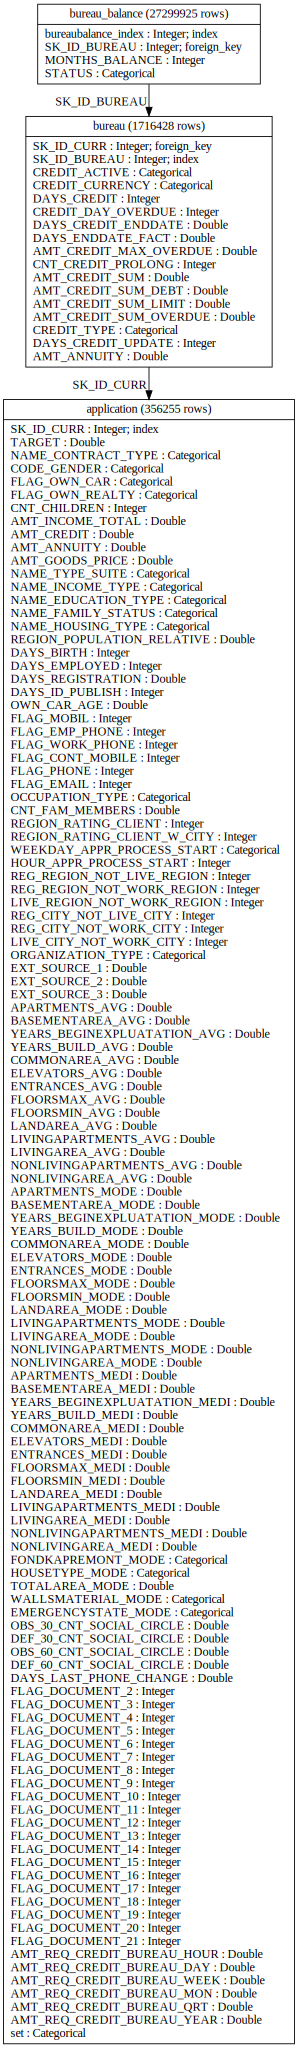

In [ ]:
es.plot()

## Feature Primitives

In [ ]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,all,aggregation,True,False,Calculates if all values are 'True' in a list.,"<ColumnSchema (Logical Type = Boolean)>, <ColumnSchema (Logical Type = BooleanNullable)>",None
1,sum,aggregation,True,True,"Calculates the total addition, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,None
2,last,aggregation,False,False,Determines the last value in a list.,<ColumnSchema>,None
3,std,aggregation,True,True,"Computes the dispersion relative to the mean value, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,None
4,median,aggregation,False,False,Determines the middlemost number in a list of values.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
5,avg_time_between,aggregation,False,False,Computes the average number of seconds between consecutive events.,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,None
6,percent_true,aggregation,True,False,Determines the percent of `True` values.,"<ColumnSchema (Logical Type = Boolean)>, <ColumnSchema (Logical Type = BooleanNullable)>",None
7,num_unique,aggregation,True,True,"Determines the number of distinct values, ignoring `NaN` values.",<ColumnSchema (Semantic Tags = ['category'])>,None
8,min,aggregation,True,True,"Calculates the smallest value, ignoring `NaN` values.",<ColumnSchema (Semantic Tags = ['numeric'])>,None
9,trend,aggregation,False,False,Calculates the trend of a column over time.,"<ColumnSchema (Semantic Tags = ['numeric'])>, <ColumnSchema (Logical Type = Datetime) (Semantic ...",None


In [ ]:
primitives[primitives['type'] == 'transform'].head(10)

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
22,add_numeric,transform,True,True,Element-wise addition of two lists.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
23,cum_count,transform,False,False,Calculates the cumulative count.,"<ColumnSchema (Semantic Tags = ['foreign_key'])>, <ColumnSchema (Semantic Tags = ['category'])>",None
24,numeric_lag,transform,False,False,Shifts an array of values by a specified number of periods.,"<ColumnSchema (Semantic Tags = ['time_index'])>, <ColumnSchema (Semantic Tags = ['numeric'])>",None
25,square_root,transform,True,True,Computes the square root of a number.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
26,weekday,transform,True,True,Determines the day of the week from a datetime.,<ColumnSchema (Logical Type = Datetime)>,None
27,divide_numeric_scalar,transform,True,True,Divide each element in the list by a scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
28,is_weekend,transform,True,True,Determines if a date falls on a weekend.,<ColumnSchema (Logical Type = Datetime)>,None
29,less_than,transform,True,True,Determines if values in one list are less than another list.,"<ColumnSchema (Semantic Tags = ['numeric'])>, <ColumnSchema (Logical Type = Ordinal)>, <ColumnSc...",None
30,longitude,transform,False,False,Returns the second tuple value in a list of LatLong tuples.,<ColumnSchema (Logical Type = LatLong)>,None
31,negate,transform,True,True,Negates a numeric value.,<ColumnSchema (Semantic Tags = ['numeric'])>,None


In [ ]:
# agg_functions = ['count', 'sum', 'mode', 'max', 'min', 'median', 'std', 'skew']
agg_functions = ['count', 'sum', 'mode', 'max', 'min', 'median', 'std']

In [ ]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    n_jobs=-1,
    target_dataframe_name="application",
    agg_primitives=agg_functions,
    ignore_columns={
        'application': ['SK_ID_CURR', 'TARGET'],
        'bureau': ['SK_ID_CURR'],
        'bureau_balance': ['SK_ID_CURR']
    },
    verbose=3,
    where_primitives=['mean'] 
)

Built 281 features
Elapsed: 00:00 | Progress:   0%|          

In [ ]:
feature_matrix.head()

In [ ]:
train_ft = feature_matrix.loc[feature_matrix['set'] == 'train', :].reset_index().drop('set', axis=1)
test_ft = feature_matrix.loc[feature_matrix['set'] == 'test', :].reset_index().drop('set', axis=1)
train_ft['TARGET'] = train['TARGET']

## Modelling

In [ ]:
import pandas as pd

from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

In [ ]:
def plot_feature_importances(columns, importances, top=15):

    df = pd.DataFrame({
        'feature': columns,
        'importance': importances
    })
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:top]))), 
            df['importance_normalized'].head(top), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:top]))))
    ax.set_yticklabels(df['feature'].head(top))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
common_cols = ['SK_ID_CURR'] + list(set(train_ft.columns).intersection(set(test_ft.columns)))
test_ft = test_ft[common_cols]

In [ ]:
X = train_ft.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = train_ft['TARGET']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


In [ ]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_transformer, X_train.select_dtypes('number').columns.tolist()),
    ('categorical', cat_transformer, X_train.select_dtypes('object').columns.tolist())
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, n_jobs=-1))
])

In [ ]:
model.fit(X_train, y_train)

In [ ]:
print('ROC AUC Train FE', roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
print('ROC AUC Validation FE', roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))

In [ ]:
plot_feature_importances(X_train.columns.tolist(), model['model'].feature_importances_, top=20)